# Disruption geneation for Milano Area PT
Author Ilias Parmaksizoglou

This notebook provided a description on how to generate a disruption via a single python interface for the examined Milano area. GTFS files have been transformed to the needed standards based on GTFS_integration.ipynb file. 

We are going to need some of the existing routines to load the GTFS file. Particularly we will make use of the wrapper to read the testcase for the examined day (1st of June) in this example.

In [4]:
from TransitRouting.misc_gtfs_functions import *
from TransitRouting.raptor import raptor
import pandas as pd
import numpy as np

We will proceed to load the modified milano GTFS and break it down to its network representation 

In [5]:
area = 'milano'
stops_file, trips_file, stop_times_file, transfers_file,\
stops_dict,stoptimes_dict, footpath_dict, routes_by_stop_dict,\
idx_by_route_stop_dict,routesindx_by_stop_dict = read_testcase(f'./{area}')

Building required dictionaries
building stops dict


100%|██████████| 21917/21917 [00:04<00:00, 4778.07it/s]


Incorrect time sequence in stoptimes builder file
stops_dict done
building stoptimes dict


100%|██████████| 639/639 [00:11<00:00, 55.74it/s] 


stoptimes dict done
building routes_by_stop
routes_by_stop done
building footpath dict..


100%|██████████| 2371/2371 [00:04<00:00, 495.92it/s]


transfers_dict done
idx_by_route_stop done
routesindx_by_stop_dict done


To align with user input we will also load the trips.txt file from the local directory. 

In [6]:
# Start time at 12:05
D_TIME = pd.Timestamp(year=2023,month=6,day=1,
                    hour = 615//60,
                    minute=615%60)

# Centrale node is 4176,4181 MXP node is 4150,4155 we assume a maximum of two modes to be used and a minimum of two minutes between mode exchange
S_TIME,E_TIME,TRANSFERS,TRANS_ROUTE = raptor(3758,4155,D_TIME,1,120,
routes_by_stop_dict,stops_dict,stoptimes_dict,footpath_dict,idx_by_route_stop_dict)

print(f"The user arrives at the airport at {E_TIME} using {TRANSFERS} mode(s).")
TRANS_ROUTE

The user arrives at the airport at 2023-06-01 11:30:00 using 1 mode(s).


[('walking',
  3758,
  4151.0,
  Timedelta('0 days 00:00:02'),
  Timestamp('2023-06-01 10:15:02')),
 (Timestamp('2023-06-01 10:20:00'),
  4151,
  4155,
  Timestamp('2023-06-01 11:30:00'),
  '1003_28')]

In [22]:
trips = pd.read_csv("TransitRouting/GTFS/milano/gtfs_o/trips.txt",low_memory=False)

Now we will ask the user a series of questions, regarding the line the disruption occurred time it started and time it is expected to end.

In [23]:
key = input("What is the affected line (XP1, XP2, R28): ")
t1 = input("What is time the disruption started (in 'YYYY-MM-DDTHH:mm' format): ")
t2 = input("What is time the disruption started (in 'YYYY-MM-DDTHH:mm' format): ")
time = [np.datetime64(t1),np.datetime64(t2)]
towards = input("Is the train going to Malpensa (True/False):")
if towards == "True":
    towards = True

We then isolate the routes that could be affected based on the 'key' parameter and determined the associated trip_id for the affected line. 

In [24]:
routes = trips[trips['route_id'] == key]
routes = routes['service_id'].values.tolist()

idxs = []
for route in routes:
    towards_c = False
    list_times = (stop_times_file[stop_times_file['service_id'] == route])
    list_times = list_times.reset_index()
    temp_idxs = []
    for idx,r in list_times.iterrows():
        if r[1]>=time[0] and r[1]<=time[1]:
            temp_idxs.append(r[0])
        else:
            temp_idxs = []
            break

    if r[4] == 4150:
        towards_c = True
    
    if temp_idxs !=[] and towards_c == towards:
        idxs.append(r[-1])


In the idxs list we have all the trip_ids for the associated line. We can then modify the GTFS by removing the affected trip by the stoptimes_dict. 

In [25]:
affected_route = stoptimes_dict[idxs[0]]
mod_route = []
for route in affected_route:
    val = False
    for stop in route:
        if stop[1] >= time[0] and stop[1] <= time[1]:
            val = True
        else:
            val = False
            break
    if val == False:
        mod_route.append(route)

# Editing the GTFS
stoptimes_dict[idxs[0]] = mod_route

IndexError: list index out of range

We can test the effect for editing the file by initiating the router on a simulated trip. Let's suppose we inititate a trip from Cadorna to MXP, at 12:05 after initiating a disruption at XP1 (Cadorna-MXP) from 12:00 to 13:05. 

In [34]:
# Start time at 12:05
D_TIME = pd.Timestamp(year=2023,month=6,day=1,
                    hour = 620//60,
                    minute=620%60)

# Cadorna node is 4145, MXP node is 4150, we assume a maximum of two modes to be used and a minimum of two minutes between mode exchange
S_TIME,E_TIME,TRANSFERS,TRANS_ROUTE = raptor(4148,4218,D_TIME,1,120,
routes_by_stop_dict,stops_dict,stoptimes_dict,footpath_dict,idx_by_route_stop_dict)

print(f"The user arrives at the airport at {E_TIME} using {TRANSFERS} mode(s).")
TRANS_ROUTE

The user arrives at the airport at None using None mode(s).


Alternatively, simulating the same trip without a disruption. 

In [ ]:
stoptimes_dict[idxs[0]] = affected_route

# Start time at 12:05
D_TIME = pd.Timestamp(year=2023,month=6,day=1,
                    hour = 725//60,
                    minute=725%60)

# Cadorna node is 4145, MXP node is 4150, we assume a maximum of two modes to be used and a minimum of two minutes between mode exchange
S_TIME,E_TIME,TRANSFERS,TRANS_ROUTE = raptor(4215,4150,D_TIME,2,120,
routes_by_stop_dict,stops_dict,stoptimes_dict,footpath_dict,idx_by_route_stop_dict)

print(f"The user arrives at the airport at {E_TIME} using {TRANSFERS} mode(s).")

NameError: name 'affected_route' is not defined

Let's continue by simulating a disruption by a road closure initiated by the user. Suppose that we want to shut down part of the A8 (Autostrada dei Laghi) highway that lead to MXP.

In [ ]:
# This will be expanded
relations = {"A8": 374766 }
key = input("Which road you want to close: ").capitalize()
key = relations[key]

We will then break down the network to its base components and isolate the geometry to just the A8, in order to create an exclusion zone in the shape of a polygon. 

In [ ]:
import osmium as o
import pandas as pd

# Create a WKBFactory object from the osmium library
wkbfab = o.geom.WKBFactory()

class RelationTimelineHandler(o.SimpleHandler):
    def __init__(self):
        super(RelationTimelineHandler, self).__init__()
        self.ways = []

    def relation(self, r):
        # Check if the relation's id matches the specified id (374766)
        if r.id == key:
            # Extract all way references from the relation and store in self.ways list
            self.ways = [m.ref for m in r.members]
            # Create an empty dictionary with way references as keys
            # The values will be lists to store the nodes' geometries later
            self.ways_dict = dict(zip(self.ways, [[]] * len(self.ways)))

class RoadLengthHandler(o.SimpleHandler):
    def __init__(self, ways_dict):
        super(RoadLengthHandler, self).__init__()
        self.ways_dict = ways_dict

    def way(self, w):
        # Check if the way's id exists in the ways_dict dictionary
        if w.id in self.ways_dict.keys():
            points = []
            # Extract and store the nodes' latitude and longitude coordinates for the way
            for n in w.nodes:
                sp2 = str(n).split('/')
                sp1 = str(sp2[0]).split('@')
                points.append((float(sp1[1]), float(sp2[1])))
            # Update the ways_dict with the geometry information for the way
            self.ways_dict[w.id] = points

def main(osmfile):
    # Initialize RelationTimelineHandler to process the OSM file and extract way references
    r = RelationTimelineHandler()
    # Set 'locations' to True to cache node locations for geometry extraction
    r.apply_file(osmfile, locations=True)

    # Initialize RoadLengthHandler and pass the ways dictionary to store geometries
    w = RoadLengthHandler(r.ways_dict)
    # Process the OSM file again to get the geometries for the ways
    w.apply_file(osmfile, locations=True)

    return w

if __name__ == '__main__':
    # Call the main function with the OSM file path as input
    b = main('ORS/milan.osm.pbf')

Let us now create a polygon out of the road area extracted from the OSM relation. We can also draw the polygon that the exlcusion area defines.

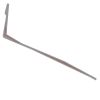

In [ ]:
from shapely.geometry import Polygon, mapping, MultiPolygon, LineString, Point

flat_dict = {"A8":b.ways_dict}
flat_dict['A8'] = [x for x in b.ways_dict.values()]
flat_dict['A8'] = [x for x in b.ways_dict.values()]
flat_dict['A8'] =  [[item[0],item[1]] for sublist in flat_dict['A8']  for item in sublist]
flat_dict['A8'].append(flat_dict['A8'][0])
poly = Polygon([[p[0], p[1]] for p in flat_dict['A8']])
poly

Realistically, the disruption would not affect the entire road so let us assume that it only affects a specific part of the road. Let' exclude a part of the road and visualize it via folium. 

In [ ]:
import folium

flat_dict = {"A8":b.ways_dict}
flat_dict['A8'] = [x for x in b.ways_dict.values()][15:40]
flat_dict['A8'] =  [[item[0],item[1]] for sublist in flat_dict['A8']  for item in sublist]
flat_dict['A8'].append(flat_dict['A8'][0])
poly = Polygon([[p[0], p[1]] for p in flat_dict['A8']])

avoid_polygon = {
        "coordinates": [
            flat_dict['A8']
        ],
        "type": "Polygon"
      }

m = folium.Map(location=[45.60524,8.94081],
              zoom_start=12)

# Plot the exclusion zone
exclude = [(x[1],x[0]) for x in flat_dict['A8']]
folium.PolyLine(exclude,
                color='red',
                weight=10,
                opacity=0.8).add_to(m)

m

We can know check the effect of the disruption when initating the router, with or without it for a user going to Malpensa via car and starting near Rescaldina. For that we need to initiate the ORS router.

In [ ]:
import openrouteservice
import subprocess
global client

subprocess.Popen('wsl ~ docker compose -f ~/milano/docker-compose.yml up', shell=True)
client = openrouteservice.Client(base_url='http://localhost:8080/ors')

request_params = {'coordinates': [[9.2411007,45.5146718],[8.71041,45.62779]],
                 'format_out': 'geojson',
                 'profile': 'driving-car',
                 'preference': 'recommended',
                 'instructions': True}

request_params['options'] = {'avoid_polygons': avoid_polygon}

route_directions = client.directions(**request_params)

loc = route_directions['features'][0]['geometry']['coordinates']
loc = [(x[1],x[0]) for x in loc]
folium.PolyLine(loc,
                color='blue',
                weight=5,
                opacity=0.8).add_to(m)
print(route_directions['features'][0]['properties']['summary'])
m

{'distance': 62506.1, 'duration': 3412.9}


Now let us see what would happen in case there was no disruption for the same route.

In [ ]:
request_params = {'coordinates': [[9.2411007,45.5146718],[8.71041,45.62779]],
                 'format_out': 'geojson',
                 'profile': 'driving-car',
                 'preference': 'recommended',
                 'instructions': True}

route_directions = client.directions(**request_params)

loc = route_directions['features'][0]['geometry']['coordinates']
loc = [(x[1],x[0]) for x in loc]
folium.PolyLine(loc,
                color='yellow',
                weight=5,
                opacity=0.8).add_to(m)
print(route_directions['features'][0]['properties']['summary'])
m

{'distance': 61889.6, 'duration': 3285.5}


We see that there is a seven minute increase in travel time! 